In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

### ECFP4

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

def extract_morgan(smiles, targets):
    x,X,y = [],[],[]
    for sm,target in zip(smiles,targets):
        mol = Chem.MolFromSmiles(sm)
        if mol is None:
            print(sm)
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        x.append(sm)
        X.append(bit2np(fp))
        y.append(target)
    return x,np.array(X),np.array(y)

### ST, RNN, BERT

In [4]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('data/vocab.pkl')

trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 3)
trfm.load_state_dict(torch.load('.save/trfm_12_23000.pkl'))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

rnn = RNNSeq2Seq(len(vocab), 256, len(vocab), 3)
rnn.load_state_dict(torch.load('.save/seq2seq_1.pkl'))
rnn.eval()
print('Total parameters:', sum(p.numel() for p in rnn.parameters()))

bert = BERT(len(vocab), hidden=256, n_layers=8, attn_heads=8, dropout=0)
bert.load_state_dict(torch.load('../result/chembl/ep00_it010000.pkl'))
bert.eval()
print('Total parameters:', sum(p.numel() for p in bert.parameters()))

Total parameters: 4245037
Total parameters: 4713517
Total parameters: 6330368


### GC

In [2]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

## HIV

In [5]:
df = pd.read_csv('data/hiv.csv')
print(df.shape)
df.head()

(41127, 3)


,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


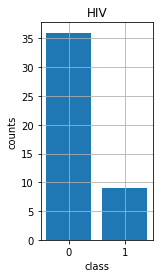

In [8]:
df_large = df[np.array(list(map(len, df['smiles'])))>218]

keys = ['0', '1']
bottom = df_large.groupby('HIV_active').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

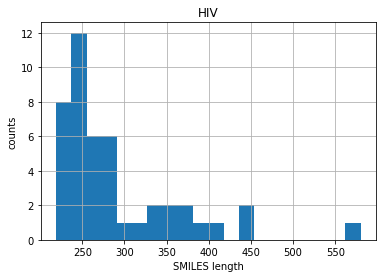

In [9]:
plt.hist(list(map(len, df_large['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

In [6]:
df_train = df[np.array(list(map(len, df['smiles'])))<=218]
df_test = df[np.array(list(map(len, df['smiles'])))>218]

In [8]:
def ablation_hiv(X, X_test, y, y_test, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = MLPClassifier(max_iter=1000)
        if rate==1:
            X_train, y_train = X,y
        else:
            X_train, _, y_train, __ = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        auc[i] = roc_auc_score(y_test, y_score[:,1])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

In [4]:
def ablation_hiv_dc(dataset, test_data, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = GraphConvModel(n_tasks=1, batch_size=64, mode='classification')
        splitter = dc.splits.RandomStratifiedSplitter()
        train_data, _, __ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        clf.fit(train_data)
        metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score)]
        scores = clf.evaluate(test_data, metrics)
        auc[i] = scores['roc_auc_score']
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

### ST

In [9]:
x_split = [split(sm) for sm in df_train['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)
x_split = [split(sm) for sm in df_test['smiles'].values]
xid, _ = get_array(x_split)
X_test = trfm.encode(torch.t(xid))
print(X_test.shape)
y, y_test = df_train['HIV_active'].values, df_test['HIV_active'].values

There are 41082 molecules. It will take a little time.
(41082, 1024)
SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES

In [9]:
scores = []
for rate in rates:
    score_dic = ablation_hiv(X, X_test, y, y_test, rate, 20)
    print(rate, score_dic)
    scores.append(score_dic['auc mean'])
print(np.mean(scores))

0.0125 {'auc mean': 0.5862654320987655, 'auc std': 0.14652686355106523}
0.025 {'auc mean': 0.5631172839506172, 'auc std': 0.11280209739337771}
0.05 {'auc mean': 0.6125, 'auc std': 0.14407490386105684}
0.1 {'auc mean': 0.5421296296296296, 'auc std': 0.13119017677727712}
0.2 {'auc mean': 0.5924382716049382, 'auc std': 0.15169203612117552}
0.4 {'auc mean': 0.6316358024691358, 'auc std': 0.11952566463707663}
0.8 {'auc mean': 0.7474537037037037, 'auc std': 0.08832672645487213}
0.6107914462081129


In [10]:
score_dic = ablation_hiv(X, X_test, y, y_test, 1, 20)
print(score_dic)

{'auc mean': 0.7293981481481482, 'auc std': 0.05145690962211546}


### ECFP

In [11]:
x,X,y = extract_morgan(df_train['smiles'].values, df_train['HIV_active'].values)
print(len(X), len(y))
x,X_test,y_test = extract_morgan(df_test['smiles'].values, df_test['HIV_active'].values)
print(len(X_test), len(y_test))

41082 41082
45 45


In [12]:
scores = []
for rate in rates:
    score_dic = ablation_hiv(X, X_test, y, y_test, rate, 20)
    print(rate, score_dic)
    scores.append(score_dic['auc mean'])
print(np.mean(scores))

0.0125 {'auc mean': 0.5419753086419754, 'auc std': 0.04503846854450115}
0.025 {'auc mean': 0.5503086419753087, 'auc std': 0.0564072236675212}
0.05 {'auc mean': 0.5694444444444444, 'auc std': 0.08849201955412457}
0.1 {'auc mean': 0.5827160493827162, 'auc std': 0.11926366834883169}
0.2 {'auc mean': 0.6459876543209876, 'auc std': 0.13795329598523573}
0.4 {'auc mean': 0.755246913580247, 'auc std': 0.08677780763643579}
0.8 {'auc mean': 0.8388888888888889, 'auc std': 0.06304612034579853}
0.640652557319224


In [13]:
score_dic = ablation_hiv(X, X_test, y, y_test, 1, 20)
print(score_dic)

{'auc mean': 0.8560185185185183, 'auc std': 0.03140384702527043}


### RNN

In [14]:
x_split = [split(sm) for sm in df_train['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)
x_split = [split(sm) for sm in df_test['smiles'].values]
xid, _ = get_array(x_split)
X_test = rnn.encode(torch.t(xid))
print(X_test.shape)
y, y_test = df_train['HIV_active'].values, df_test['HIV_active'].values

There are 41082 molecules. It will take a little time.
(41082, 1024)
SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES

In [15]:
scores = []
for rate in rates:
    score_dic = ablation_hiv(X, X_test, y, y_test, rate, 20)
    print(rate, score_dic)
    scores.append(score_dic['auc mean'])
print(np.mean(scores))

0.0125 {'auc mean': 0.6413580246913579, 'auc std': 0.11069279967556718}
0.025 {'auc mean': 0.6655864197530865, 'auc std': 0.056627812535610146}
0.05 {'auc mean': 0.644753086419753, 'auc std': 0.07297865449282823}
0.1 {'auc mean': 0.6932098765432098, 'auc std': 0.06506711622922942}
0.2 {'auc mean': 0.7206018518518518, 'auc std': 0.08554099486619125}
0.4 {'auc mean': 0.6810185185185185, 'auc std': 0.06736796063488669}
0.8 {'auc mean': 0.7066358024691357, 'auc std': 0.05058786972816301}
0.6790233686067019


In [16]:
score_dic = ablation_hiv(X, X_test, y, y_test, 1, 20)
print(score_dic)

{'auc mean': 0.6912037037037038, 'auc std': 0.09106494426547503}


### GC

In [5]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['HIV_active'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/hiv.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/hiv.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 34.156 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 35.162 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 36.376 s
Loading shard 4 of size 8192.
Featurizing sample 0
Featuri

In [6]:
train_data = dataset.select(np.where(np.array(list(map(len, df['smiles'])))<=218)[0])
test_data = dataset.select(np.where(np.array(list(map(len, df['smiles'])))>218)[0])

scores = []
for rate in rates:
    score_dic = ablation_hiv_dc(train_data, test_data, rate, 20)
    print(rate, score_dic)
    scores.append(score_dic['auc mean'])
print(np.mean(scores))

TIMING: dataset construction took 62.290 s
Loading dataset from disk.
TIMING: dataset construction took 20.102 s
Loading dataset from disk.
TIMING: dataset construction took 0.422 s
Loading dataset from disk.
TIMING: dataset construction took 40.842 s
Loading dataset from disk.
TIMING: dataset construction took 40.622 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7407407407407407]
TIMING: dataset construction took 0.252 s
Loading dataset from disk.
TIMING: dataset construction took 41.058 s
Loading dataset from disk.
TIMING: dataset construction took 40.823 s
Loading dataset from disk.
computed_metrics: [0.617283950617284]
TIMING: dataset construction took 0.437 s
Loading dataset from disk.
TIMING: dataset construction took 41.790 s
Loading dataset from disk.
TIMING: dataset construction took 41.036 s
Loading dataset from disk.
computed_metrics: [0.45987654320987653]
TIMING: dataset construction took 0.602 s
Loading dataset from disk.
TIMING: dataset construction took 42.796 s
Loading dataset from disk.
TIMING: dataset construction took 42.979 s
Loading dataset from disk.
computed_metrics: [0.6604938271604939]
TIMING: dataset construction took 0.290 s
Loading dataset from disk.
TIMING: dataset construction took 42.907 s
Loading dataset from disk.
TIMING: dataset construction took 41.147 s
Loading dataset from disk.
computed

computed_metrics: [0.6450617283950617]
TIMING: dataset construction took 0.845 s
Loading dataset from disk.
TIMING: dataset construction took 40.368 s
Loading dataset from disk.
TIMING: dataset construction took 39.981 s
Loading dataset from disk.
computed_metrics: [0.6604938271604939]
TIMING: dataset construction took 0.731 s
Loading dataset from disk.
TIMING: dataset construction took 41.865 s
Loading dataset from disk.
TIMING: dataset construction took 40.573 s
Loading dataset from disk.
computed_metrics: [0.5370370370370371]
TIMING: dataset construction took 1.214 s
Loading dataset from disk.
TIMING: dataset construction took 40.154 s
Loading dataset from disk.
TIMING: dataset construction took 39.725 s
Loading dataset from disk.
computed_metrics: [0.8024691358024691]
TIMING: dataset construction took 1.098 s
Loading dataset from disk.
TIMING: dataset construction took 42.479 s
Loading dataset from disk.
TIMING: dataset construction took 41.651 s
Loading dataset from disk.
computed

TIMING: dataset construction took 36.613 s
Loading dataset from disk.
computed_metrics: [0.5401234567901234]
TIMING: dataset construction took 4.005 s
Loading dataset from disk.
TIMING: dataset construction took 37.509 s
Loading dataset from disk.
TIMING: dataset construction took 37.128 s
Loading dataset from disk.
computed_metrics: [0.6820987654320987]
TIMING: dataset construction took 3.768 s
Loading dataset from disk.
TIMING: dataset construction took 37.242 s
Loading dataset from disk.
TIMING: dataset construction took 37.010 s
Loading dataset from disk.
computed_metrics: [0.521604938271605]
TIMING: dataset construction took 3.799 s
Loading dataset from disk.
TIMING: dataset construction took 37.627 s
Loading dataset from disk.
TIMING: dataset construction took 37.220 s
Loading dataset from disk.
computed_metrics: [0.7407407407407407]
TIMING: dataset construction took 4.253 s
Loading dataset from disk.
TIMING: dataset construction took 37.222 s
Loading dataset from disk.
TIMING: d

TIMING: dataset construction took 32.592 s
Loading dataset from disk.
computed_metrics: [0.617283950617284]
0.2 {'auc std': 0.07716913531857271, 'auc mean': 0.6438271604938273}
TIMING: dataset construction took 16.732 s
Loading dataset from disk.
TIMING: dataset construction took 24.272 s
Loading dataset from disk.
TIMING: dataset construction took 24.716 s
Loading dataset from disk.
computed_metrics: [0.4537037037037037]
TIMING: dataset construction took 15.886 s
Loading dataset from disk.
TIMING: dataset construction took 25.192 s
Loading dataset from disk.
TIMING: dataset construction took 25.132 s
Loading dataset from disk.
computed_metrics: [0.5740740740740741]
TIMING: dataset construction took 16.026 s
Loading dataset from disk.
TIMING: dataset construction took 24.997 s
Loading dataset from disk.
TIMING: dataset construction took 24.861 s
Loading dataset from disk.
computed_metrics: [0.7685185185185186]
TIMING: dataset construction took 17.079 s
Loading dataset from disk.
TIMING

TIMING: dataset construction took 8.555 s
Loading dataset from disk.
TIMING: dataset construction took 8.085 s
Loading dataset from disk.
computed_metrics: [0.5987654320987654]
TIMING: dataset construction took 35.332 s
Loading dataset from disk.
TIMING: dataset construction took 7.510 s
Loading dataset from disk.
TIMING: dataset construction took 7.368 s
Loading dataset from disk.
computed_metrics: [0.7314814814814814]
TIMING: dataset construction took 33.929 s
Loading dataset from disk.
TIMING: dataset construction took 8.334 s
Loading dataset from disk.
TIMING: dataset construction took 8.216 s
Loading dataset from disk.
computed_metrics: [0.6512345679012346]
TIMING: dataset construction took 33.538 s
Loading dataset from disk.
TIMING: dataset construction took 9.017 s
Loading dataset from disk.
TIMING: dataset construction took 8.748 s
Loading dataset from disk.
computed_metrics: [0.7345679012345678]
TIMING: dataset construction took 33.991 s
Loading dataset from disk.
TIMING: data

In [8]:
score_dic = ablation_hiv_dc(train_data, test_data, 1, 20)
print(rate, score_dic)

TIMING: dataset construction took 42.882 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7407407407407407]
TIMING: dataset construction took 42.898 s
Loading dataset from disk.
computed_metrics: [0.7438271604938271]
TIMING: dataset construction took 43.568 s
Loading dataset from disk.
computed_metrics: [0.5987654320987654]
TIMING: dataset construction took 42.949 s
Loading dataset from disk.
computed_metrics: [0.478395061728395]
TIMING: dataset construction took 43.000 s
Loading dataset from disk.
computed_metrics: [0.8148148148148149]
TIMING: dataset construction took 45.167 s
Loading dataset from disk.
computed_metrics: [0.7067901234567902]
TIMING: dataset construction took 44.496 s
Loading dataset from disk.
computed_metrics: [0.808641975308642]
TIMING: dataset construction took 43.518 s
Loading dataset from disk.
computed_metrics: [0.7438271604938271]
TIMING: dataset construction took 43.286 s
Loading dataset from disk.
computed_metrics: [0.8333333333333333]
TIMING: dataset construction took 43.622 s
Loading dataset from disk.
computed_metrics: [0.